### We plan to compute the L2 norm as convergenc analysis:




In computational mechanics, the L2 norm (or L2 error) is a crucial tool for measuring the error between the numerical solution and the analytical solution. When performing convergence analysis, handling the L2 norm generally involves the following steps:

1. **Define the L2 Norm:**
   For a function \( u \) defined on a domain $ \Omega $, the L2 norm is defined as:
   $$
   \|u\|_{L2} = \left( \int_{\Omega} |u(x)|^2 \, dx \right)^{1/2}
   $$

2. **Compute the Error:**
   Let $u$ be the exact solution and $u_h$ be the numerical solution. The error is defined as $ e = u - u_h $. We are interested in the L2 norm of the error:
   $$
   \|e\|_{L2} = \left( \int_{\Omega} |u(x) - u_h(x)|^2 \, dx \right)^{1/2}
   $$

3. **Discretize the Error Calculation:**
   In practice, the domain $ \Omega $ is typically discretized into a finite number of elements, so the integral can be approximated using numerical integration methods (e.g., Gaussian quadrature). The discrete L2 norm of the error is calculated as:
   $$
   \|e\|_{L2} \approx \left( \sum_{i=1}^{N} w_i |u(x_i) - u_h(x_i)|^2 \right)^{1/2}
   $$
   where $ w_i $ are the numerical integration weights and $ x_i $ are the integration points.



4. **Perform Convergence Analysis:**
   To analyze the convergence of the numerical solution, we typically refine the mesh (i.e., reduce the element size \( h \)), calculate the L2 norm of the error for different mesh sizes, and observe how the L2 error changes with the mesh size. Ideally, the error should satisfy a convergence rate, such as:
   $$
   \|e\|_{L2} \leq Ch^p
   $$
   where \( C \) is a constant and \( p \) is the order of convergence.

5. **Conduct Numerical Experiments and Validation:**
   Through numerical experiments, compute the L2 error for different mesh sizes and plot the error versus mesh size on a log-log plot. In this plot, the slope of the line represents the convergence rate \( p \).

6. **Error Estimation and Theoretical Analysis:**
   Combine specific finite element theory to provide theoretical error estimates and compare these with the numerical experiment results. For example, for a second-order elliptic equation, the finite element method theoretically has an $ O(h^2) $ convergence rate in the L2 norm.


```python
# Pseudocode example for computing L2 norm error
import numpy as np

def compute_l2_error(u_exact, u_numeric, weights, points):
    error = 0.0
    for i in range(len(points)):
        error += weights[i] * (u_exact(points[i]) - u_numeric(points[i]))**2
    return np.sqrt(error)

# Assuming we have two solution functions u_exact and u_numeric, as well as integration points and weights
points = [...]
weights = [...]
u_exact = lambda x: ...  # Exact solution
u_numeric = lambda x: ...  # Numerical solution

l2_error = compute_l2_error(u_exact, u_numeric, weights, points)
print(f"L2 error: {l2_error}")
```

### We should apply Johnson(1985) solution as analytical solution, our computation is for demi-sphere and flat surface.

We would like to have a generalized Maxwell model with one pure elastic branch and one Maxwell branch. For parameter setting, we would like to have $2*G_\infty$ at t=0.

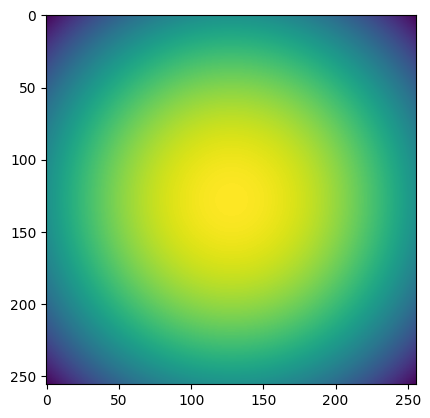

In [1]:
import tamaas as tm
import matplotlib.pyplot as plt

import tamaas.utils
import numpy as np

# parallel computation
tm.initialize(8)

# discretization
n = 256 #[256, 512, 1024]



##load(constant)
W = 1e0  # Total load

L = 1.  # Domain size
Radius = 0.01

physical_size = [L, L]
discritization = [n, n]
model = tm.Model(tm.model_type.basic_2d, physical_size, discritization)

model.E = 3
model.nu = 0.5

E_star = model.E / (1 - model.nu**2)

shear_modulus = [model.mu]
characteristic_time = [1] 


#We apply analytical solution in Hertz contact
surface = tm.utils.hertz_surface(physical_size, discritization,Radius)

plt.imshow(surface)

In [2]:
G_inf = model.mu
G = shear_modulus

print('G_inf:', G_inf, ' G: ' + str(G))

tau = characteristic_time#[1]#[0.1, 1] #relaxation time
eta = [g * t for g, t in zip(G, tau)]

print('tau:', tau, ' eta: ' + str(eta))

nu = 0.5


Ac_Johnson_ref = []
g_1 = 2*(G[0] + G_inf)
g_2 = -g_1*(2*G_inf/(2*G_inf-g_1))

e_1 = 2 * (G[0] + G_inf) * (1+model.nu)
K = 2 * G_inf * (1+model.nu)
tau_c = [t*e_1/K for t in tau]

tau_c

G_inf: 1.0  G: [1.0]
tau: [1]  eta: [1.0]


[2.0]

#### Normalization:

$$
A_c / L^2
$$

$$
t / \tau_1
$$

$$
F_N /\left(E^* L^2 h^\prime_{\mathrm{rms}}\right)
$$

In [3]:
Ac_tamaas = []

#solve for target pressure
p_target = W / (L**2) #avarge pressure
#normalized pressure
h_rms_prime = tm.Statistics2D.computeSpectralRMSSlope(surface)

p_target = p_target / (E_star*h_rms_prime)


Fn_Johnson = W / (E_star*h_rms_prime)

#solver.solve(p_target)
time_steps_list = np.geomspace(4,800,10 , dtype=int)#[2, 20, 30, 50, 80, 100, 150, 250, 400, 800, 1200, 1600]
#L2_norms = []
error_list = []

##time
t0 = 0
t1 = 10 
## normalized time
t0 = 0/np.min(characteristic_time)
t1 = 10/np.min(characteristic_time)



In [4]:
##Hertz solution at t0 
G_maxwell_t0 = 0
for k in range(len(G)):
    G_maxwell_t0 += G[k]
G_effective_t0 = G_inf + G_maxwell_t0
E_effective_t0 = 2*G_effective_t0*(1+nu)/(1-nu**2)

p0_t0 = (6*W*(E_effective_t0)**2/(np.pi**3*Radius**2))**(1/3)
a_t0 = (3*W*Radius/(4*(E_effective_t0)))**(1/3)
##Hertz solution at t_inf
E_effective_inf = 2*G_inf*(1+nu)/(1-nu**2)

p0_t_inf = (6*W*(E_effective_inf)**2/(np.pi**3*Radius**2))**(1/3)
a_t_inf = (3*W*Radius/(4*(E_effective_inf)))**(1/3)


Ac_hertz_t0 = np.pi*a_t0**2
Ac_hertz_t_inf = np.pi*a_t_inf**2

 Iter          Cost_f           Error
    0    1.615190e-06    5.270442e-01
   32    2.302441e-04    6.534480e-13
 Iter          Cost_f           Error
    0    1.168062e-04    3.773603e-04
   21    2.942668e-04    9.592496e-13
 Iter          Cost_f           Error
    0    1.342353e-04    1.447700e-04
   20    3.200812e-04    8.727918e-13
 Iter          Cost_f           Error
    0    1.415863e-04    4.103164e-05
   14    3.308769e-04    4.083889e-13


[np.float64(0.0014801025390625), np.float64(0.0015411376953125), np.float64(0.0015411376953125)]
[np.float64(0.0014389986226841958), np.float64(0.001551284144602309), np.float64(0.001582706536072017)]
3
3


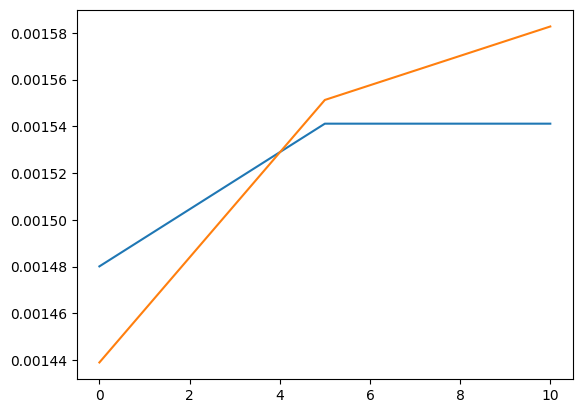

 Iter          Cost_f           Error
    0    6.598069e-05    4.549573e-04
   19    2.377099e-04    7.574644e-13
 Iter          Cost_f           Error
    0    1.249006e-04    3.471737e-04
   21    3.093177e-04    6.591403e-13
 Iter          Cost_f           Error
    0    1.514120e-04    1.756144e-04
   14    3.474206e-04    6.776054e-13
 Iter          Cost_f           Error
    0    1.660343e-04    1.020094e-04
   13    3.683691e-04    6.523357e-13
 Iter          Cost_f           Error
    0    1.741373e-04    4.170998e-05
   18    3.800149e-04    8.168266e-13
 Iter          Cost_f           Error
    0    1.787163e-04    2.180405e-05
   14    3.866371e-04    2.729300e-13
 Iter          Cost_f           Error
    0    1.813290e-04    1.332362e-05
   13    3.903919e-04    7.521986e-13


[np.float64(0.0013580322265625), np.float64(0.0014801025390625), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0016632080078125)]
[np.float64(0.001322952599581368), np.float64(0.0014651124613502986), np.float64(0.0015322263164906562), np.float64(0.0015645490294683823), np.float64(0.0015802510041920716), np.float64(0.00158790937733137)]
6
6


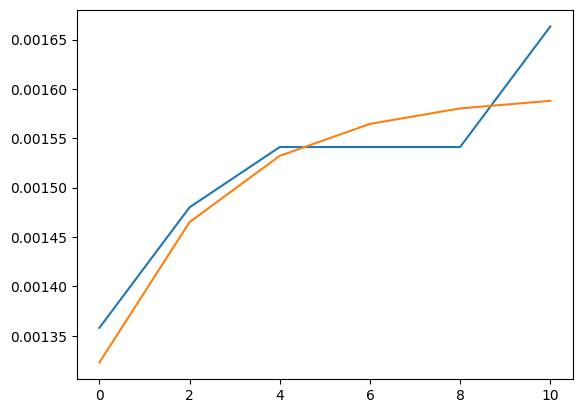

 Iter          Cost_f           Error
    0    6.534333e-05    5.251549e-04
   20    2.448754e-04    3.913004e-13
 Iter          Cost_f           Error
    0    1.255185e-04    3.439401e-04
   18    3.144372e-04    8.987789e-13
 Iter          Cost_f           Error
    0    1.577001e-04    2.073681e-04
   14    3.598694e-04    9.008081e-14
 Iter          Cost_f           Error
    0    1.791058e-04    1.223176e-04
   19    3.899416e-04    3.315985e-13
 Iter          Cost_f           Error
    0    1.934414e-04    7.521686e-05
   14    4.102957e-04    5.146816e-13
 Iter          Cost_f           Error
    0    2.031800e-04    5.422905e-05
   13    4.241581e-04    6.250131e-13
 Iter          Cost_f           Error
    0    2.097608e-04    2.944334e-05
   13    4.336533e-04    3.423797e-13
 Iter          Cost_f           Error
    0    2.142809e-04    1.601883e-05
   18    4.402047e-04    5.979136e-13
 Iter          Cost_f           Error
    0    2.174594e-04    1.445114e-05
   14    4.4

[np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0016632080078125), np.float64(0.0016632080078125), np.float64(0.0016632080078125)]
[np.float64(0.001221909412007198), np.float64(0.0013548430897887354), np.float64(0.0014389986226841958), np.float64(0.001493151827654221), np.float64(0.0015283198760943262), np.float64(0.001551284144602309), np.float64(0.0015663305312503069), np.float64(0.0015762102980813142), np.float64(0.001582706536072017), np.float64(0.0015869818367333685), np.float64(0.0015897971413495937)]
11
11


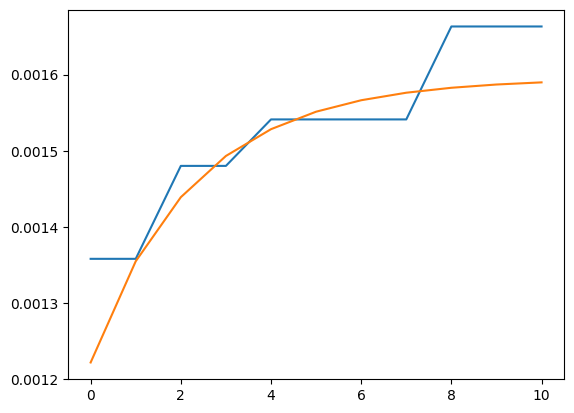

 Iter          Cost_f           Error
    0    6.502244e-05    5.810190e-04
   22    2.524856e-04    6.737962e-13
 Iter          Cost_f           Error
    0    1.173239e-04    2.646115e-04
   14    3.087419e-04    1.651600e-13
 Iter          Cost_f           Error
    0    1.486509e-04    1.919230e-04
   19    3.523387e-04    9.488710e-13
 Iter          Cost_f           Error
    0    1.734811e-04    1.283534e-04
   14    3.863215e-04    1.884949e-13
 Iter          Cost_f           Error
    0    1.928181e-04    1.156591e-04
   13    4.132673e-04    3.429036e-13
 Iter          Cost_f           Error
    0    2.080265e-04    7.906586e-05
   13    4.345343e-04    4.143485e-13
 Iter          Cost_f           Error
    0    2.200183e-04    5.435601e-05
   14    4.514658e-04    1.164721e-13
 Iter          Cost_f           Error
    0    2.296460e-04    3.748487e-05
   14    4.650658e-04    2.837516e-13
 Iter          Cost_f           Error
    0    2.373888e-04    4.181151e-05
   13    4.7

[np.float64(0.0011138916015625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0016632080078125), np.float64(0.0016632080078125), np.float64(0.0016632080078125), np.float64(0.0016632080078125), np.float64(0.0016632080078125), np.float64(0.0016632080078125), np.float64(0.0016632080078125), np.float64(0.0016632080078125)]
[np.float64(0.0011319058472074176), np.float64(0.0012290896195675703), np.float64(0.001304571141049845), np.float64(0.0013637513797295935), np.float64(0.0014104507692481321), np.float64(0.001447471171934515), np.float64(0.0014769178090777285), np.float64(0.0015003994349761446), np.float64(0.001

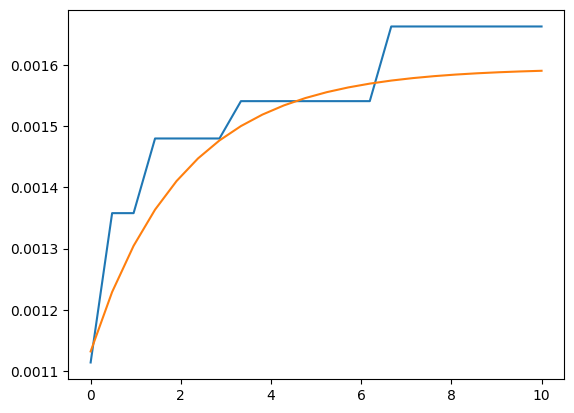

 Iter          Cost_f           Error
    0    6.456079e-05    6.102714e-04
   19    2.583401e-04    4.731272e-13
 Iter          Cost_f           Error
    0    1.050204e-04    1.318067e-04
   17    2.973127e-04    4.902672e-13
 Iter          Cost_f           Error
    0    1.309350e-04    1.516150e-04
   14    3.318391e-04    2.081797e-13
 Iter          Cost_f           Error
    0    1.525270e-04    1.290228e-04
   12    3.616610e-04    5.481520e-13
 Iter          Cost_f           Error
    0    1.713031e-04    1.012713e-04
   12    3.872964e-04    4.089406e-13
 Iter          Cost_f           Error
    0    1.874646e-04    7.986333e-05
   18    4.094764e-04    9.283276e-13
 Iter          Cost_f           Error
    0    2.016404e-04    6.306123e-05
   14    4.288518e-04    1.687454e-13
 Iter          Cost_f           Error
    0    2.139170e-04    6.769842e-05
   13    4.458408e-04    1.702718e-13
 Iter          Cost_f           Error
    0    2.245828e-04    5.395952e-05
   13    4.6

[np.float64(0.0010528564453125), np.float64(0.0011138916015625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0016632080078125), np.float64(0.0016632080078125), np.float64(0.0016632080078125), np.float64(0.0016632080078125), np.float64(0.0016632080078125), np.float64(0.0016632080078125), np.floa

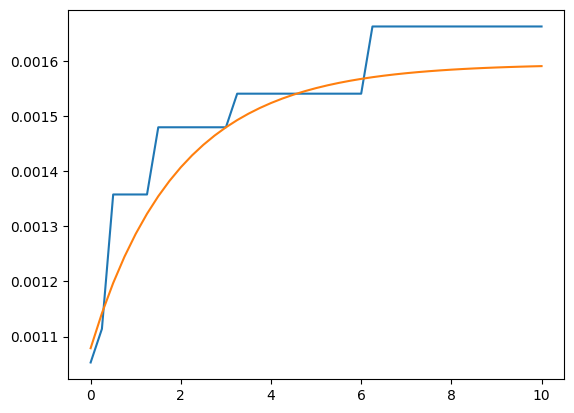

 Iter          Cost_f           Error
    0    6.404543e-05    6.251864e-04
   17    2.621210e-04    6.688710e-13
 Iter          Cost_f           Error
    0    9.553409e-05    8.770045e-05
   11    2.874922e-04    2.883934e-13
 Iter          Cost_f           Error
    0    1.125335e-04    7.562259e-05
   18    3.108053e-04    2.854176e-13
 Iter          Cost_f           Error
    0    1.289182e-04    9.424066e-05
   18    3.326485e-04    9.235583e-13
 Iter          Cost_f           Error
    0    1.439652e-04    8.412985e-05
   14    3.528524e-04    1.339673e-13
 Iter          Cost_f           Error
    0    1.577107e-04    7.864452e-05
   12    3.714834e-04    5.447973e-13
 Iter          Cost_f           Error
    0    1.703244e-04    6.809120e-05
   12    3.885229e-04    4.802266e-13
 Iter          Cost_f           Error
    0    1.818112e-04    5.906756e-05
   12    4.041470e-04    4.280269e-13
 Iter          Cost_f           Error
    0    1.923007e-04    5.132985e-05
   12    4.1

[np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0012359619140625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.float64(0.0015411376953125), np.floa

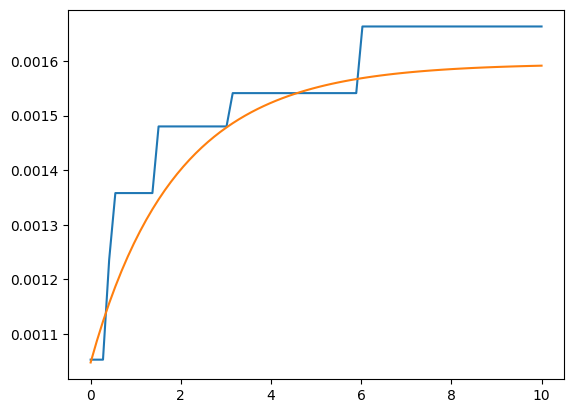

 Iter          Cost_f           Error
    0    6.361874e-05    6.332286e-04
   18    2.645362e-04    4.906964e-13
 Iter          Cost_f           Error
    0    8.907307e-05    5.361185e-05
   11    2.799126e-04    1.727771e-13
 Iter          Cost_f           Error
    0    9.968782e-05    4.924544e-05
   11    2.945575e-04    1.715915e-13
 Iter          Cost_f           Error
    0    1.097648e-04    4.526995e-05
   11    3.085179e-04    1.597205e-13
 Iter          Cost_f           Error
    0    1.193412e-04    4.164647e-05
   11    3.218372e-04    1.487268e-13
 Iter          Cost_f           Error
    0    1.287998e-04    4.047277e-05
   17    3.346364e-04    6.180945e-13
 Iter          Cost_f           Error
    0    1.380205e-04    5.262661e-05
   13    3.470316e-04    1.781906e-13
 Iter          Cost_f           Error
    0    1.468129e-04    4.861705e-05
   17    3.588627e-04    8.235398e-13
 Iter          Cost_f           Error
    0    1.553404e-04    4.469048e-05
   13    3.7

[np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0011138916015625), np.float64(0.0012359619140625), np.float64(0.0012359619140625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.float64(0.0014801025390625), np.floa

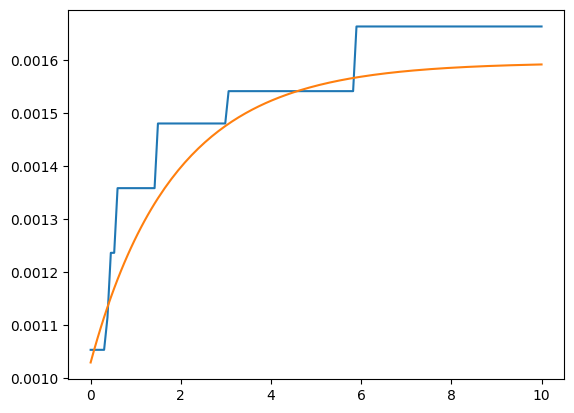

 Iter          Cost_f           Error
    0    6.333059e-05    6.374369e-04
   18    2.659541e-04    4.955406e-13
 Iter          Cost_f           Error
    0    8.481556e-05    3.145879e-05
   11    2.749297e-04    1.001343e-13
 Iter          Cost_f           Error
    0    9.118060e-05    2.997853e-05
   10    2.836602e-04    4.730539e-13
 Iter          Cost_f           Error
    0    9.735783e-05    2.857535e-05
   11    2.921551e-04    9.243537e-14
 Iter          Cost_f           Error
    0    1.033550e-04    2.724476e-05
   10    3.004230e-04    9.462002e-13
 Iter          Cost_f           Error
    0    1.091795e-04    2.598257e-05
   11    3.084723e-04    8.540063e-14
 Iter          Cost_f           Error
    0    1.148382e-04    2.478485e-05
   10    3.163110e-04    9.120258e-13
 Iter          Cost_f           Error
    0    1.203377e-04    2.364791e-05
   11    3.239465e-04    7.887380e-14
 Iter          Cost_f           Error
    0    1.256842e-04    2.256831e-05
   11    3.3

[np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0011138916015625), np.float64(0.0011138916015625), np.float64(0.0012359619140625), np.float64(0.0012359619140625), np.float64(0.0012359619140625), np.float64(0.0012359619140625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.floa

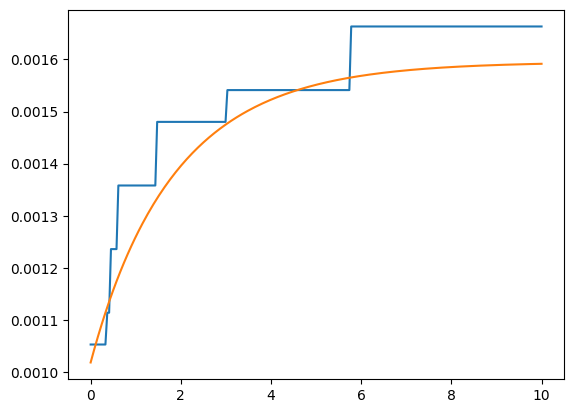

 Iter          Cost_f           Error
    0    6.315281e-05    6.396778e-04
   18    2.667653e-04    4.050695e-13
 Iter          Cost_f           Error
    0    8.221611e-05    1.802957e-05
   11    2.718937e-04    5.695480e-14
 Iter          Cost_f           Error
    0    8.591025e-05    1.754752e-05
   10    2.769428e-04    9.205241e-14
 Iter          Cost_f           Error
    0    8.954210e-05    1.707979e-05
   11    2.819143e-04    5.448653e-14
 Iter          Cost_f           Error
    0    9.311316e-05    1.662591e-05
   10    2.868101e-04    2.083619e-13
 Iter          Cost_f           Error
    0    9.662489e-05    1.618540e-05
   11    2.916316e-04    5.209460e-14
 Iter          Cost_f           Error
    0    1.000787e-04    1.575784e-05
   10    2.963804e-04    4.308679e-13
 Iter          Cost_f           Error
    0    1.034759e-04    1.534279e-05
   11    3.010581e-04    4.985667e-14
 Iter          Cost_f           Error
    0    1.068178e-04    1.493984e-05
   10    3.0

[np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0011138916015625), np.float64(0.0011138916015625), np.float64(0.0011138916015625), np.float64(0.0012359619140625), np.float64(0.0012359619140625), np.float64(0.0012359619140625), np.float64(0.0012359619140625), np.float64(0.0012359619140625), np.float64(0.0012359619140625), np.float64(0.0012359619140625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.float64(0.0013580322265625), np.floa

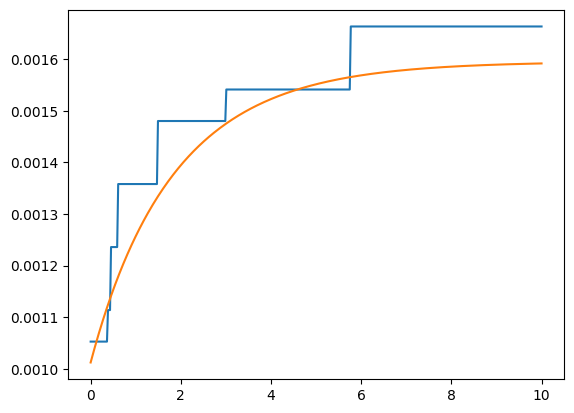

 Iter          Cost_f           Error
    0    6.304823e-05    6.408899e-04
   16    2.672231e-04    9.449025e-13
 Iter          Cost_f           Error
    0    8.069448e-05    1.019850e-05
   11    2.701189e-04    3.209990e-14
 Iter          Cost_f           Error
    0    8.279914e-05    1.004500e-05
   10    2.729896e-04    2.628405e-13
 Iter          Cost_f           Error
    0    8.488375e-05    9.894068e-06
   11    2.758355e-04    3.129815e-14
 Iter          Cost_f           Error
    0    8.694859e-05    9.745661e-06
   10    2.786568e-04    1.774556e-13
 Iter          Cost_f           Error
    0    8.899392e-05    9.599730e-06
   11    2.814539e-04    3.050209e-14
 Iter          Cost_f           Error
    0    9.102002e-05    9.456229e-06
   10    2.842270e-04    2.321474e-13
 Iter          Cost_f           Error
    0    9.302714e-05    9.315113e-06
   11    2.869766e-04    2.981112e-14
 Iter          Cost_f           Error
    0    9.501553e-05    9.176337e-06
   10    2.8

[np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.float64(0.0010528564453125), np.floa

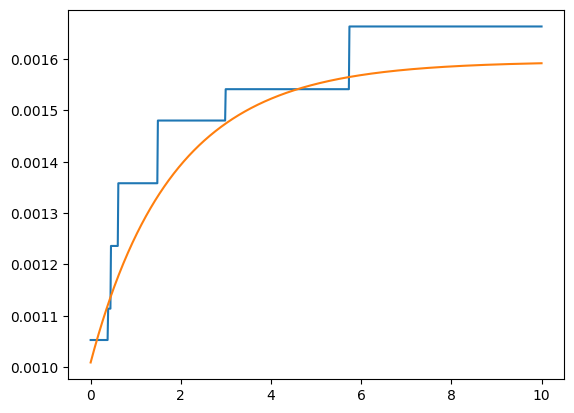

In [5]:

for time_steps in time_steps_list:
    dt = (t1 - t0) / time_steps
    Ac_tamaas = []
    Ac_Johnson_ref = []
    # Solver
    solver = tm.MaxwellViscoelastic(model, surface, 1e-12, dt, shear_modulus, characteristic_time)
    solver.reset()

    for i in range(time_steps):
        solver.solve(p_target)
        contact_area_result = np.mean(model.traction > 0) * L**2
        normalized_result = contact_area_result / L**2      ######normalized contact area
        Ac_tamaas.append(normalized_result)

    for t in np.arange(t0, t1, dt):        
        Ac_Johnson_ref.append((3 / 8 * Radius * Fn_Johnson * (1 / g_1 + 1 / g_2 * (1 - np.exp(-t / tau_c[0]))))**(2/3) * np.pi)


    Ac_tamaas = Ac_tamaas[:-1]
    Ac_Johnson_ref = Ac_Johnson_ref[1:]

    print(Ac_tamaas)
    print(Ac_Johnson_ref)
    print(len(Ac_tamaas))
    print(len(Ac_Johnson_ref))

    '''
    # Calculate L2 norm between Ac_tamaas and Ac_Johnson_ref
    L2_error = np.sqrt(np.sum((np.array(Ac_tamaas) - np.array(Ac_Johnson_ref))**2))

    # normalize L2 error
    L2_error /= np.sqrt(len(Ac_tamaas))   
    '''
    #L2_error = np.linalg.norm(np.array(Ac_tamaas) - np.array(Ac_Johnson_ref)) / np.sqrt(len(Ac_tamaas))
    L2_norm = np.sqrt(np.sum((np.array(Ac_tamaas) - np.array(Ac_Johnson_ref))**2))
    error = L2_norm / np.linalg.norm(Ac_Johnson_ref) 
    error_list.append(error)
    #L2_norms.append(L2_error)
    plt.plot(np.linspace(t0, t1, time_steps-1), Ac_tamaas, label='Tamaas')
    plt.plot(np.linspace(t0, t1, time_steps-1), Ac_Johnson_ref, label='Johnson')
    plt.show()


In [6]:
print(error_list)

[np.float64(0.02245454515977353), np.float64(0.026019525125913337), np.float64(0.04021847115441935), np.float64(0.043384285217228), np.float64(0.04541316784794424), np.float64(0.046843455606599034), np.float64(0.04705116098706578), np.float64(0.04766604733621264), np.float64(0.047746877597292965), np.float64(0.04794338866734306)]


[np.float64(2.5), np.float64(1.4285714285714286), np.float64(0.8333333333333334), np.float64(0.43478260869565216), np.float64(0.23809523809523808), np.float64(0.13333333333333333), np.float64(0.07352941176470588), np.float64(0.04065040650406504), np.float64(0.02252252252252252), np.float64(0.0125)]


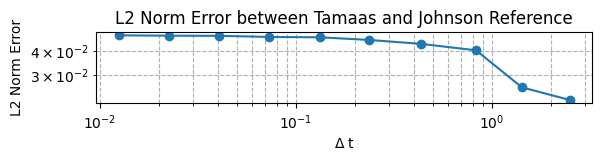

In [7]:
dt_list = [(t1 - t0) / time_steps for time_steps in time_steps_list]
print(dt_list)
# Plot log-log graph of L2 norms
plt.figure()
plt.loglog(dt_list, error_list, marker='o')
plt.xlabel('$\Delta$ t')
plt.ylabel('L2 Norm Error')
plt.title('L2 Norm Error between Tamaas and Johnson Reference')
plt.grid(True, which="both", ls="--")
plt.gca().set_aspect('equal')
plt.show()